In [3]:
import simpy
import statistics
import random

# Classe para coletar as métricas
class MetricsCollector:
    def __init__(self):
        self.waiting_times = []
        self.service_times = []
        self.abandonment_count = 0
        self.call_count = 0
        self.occupied_time = 0
        self.atendente_ids = []  # Lista para armazenar o ID do atendente de cada produto

    def record_waiting_time(self, waiting_time):
        self.waiting_times.append(waiting_time)

    def record_service_time(self, service_time):
        self.service_times.append(service_time)

    def increment_abandonment_count(self):
        self.abandonment_count += 1

    def increment_call_count(self):
        self.call_count += 1

    def record_occupied_time(self, occupied_time):
        self.occupied_time += occupied_time

    def record_atendente_id(self, atendente_id):
        self.atendente_ids.append(atendente_id)

    def calculate_average_waiting_time(self):
        return statistics.mean(self.waiting_times)

    def calculate_average_service_time(self):
        return statistics.mean(self.service_times)

    def calculate_abandonment_rate(self):
        return self.abandonment_count / self.call_count * 100 if self.call_count > 0 else 0

    def calculate_occupancy_rate(self, total_time):
        return self.occupied_time / total_time * 100 if total_time > 0 else 0

# Função que define o processo de chegada das entidades
def geraChegadas(env, nome, limiteproducao, recurso, metrics):
    print(f"Produto {nome} chega ao processo em {env.now}")

    # Fase A: Atualização do tempo
    contaChegada = 0
    while contaChegada < limiteproducao:
        taxa = distribuicao(nome)
        yield env.timeout(taxa)
        contaChegada += 1

        print(f"O produto {nome}, de posição {contaChegada}, chega em {env.now:0.1f}")

        # Fase C: Condições para as atividades ocorrerem
        # Requisita o recurso necessário para processar a entidade
        with recurso.request() as req:
            yield req
            print(f"O produto {nome}, de posição {contaChegada}, começa a ser processado pelo atendente {recurso.users.index(req)} em {env.now:0.1f}")

            start_time = env.now

            # Tempo de processamento da entidade
            tempo_processamento = random.normalvariate(20, 5)  # Exemplo de tempo de processamento com distribuição normal (média: 20, desvio padrão: 5)
            yield env.timeout(tempo_processamento)

            end_time = env.now

            print(f"O produto {nome}, de posição {contaChegada}, finaliza o processamento em {env.now:0.1f}")

            # Fase B: Checagem pelo fim de atividades
            # Registra as métricas
            metrics.record_waiting_time(env.now - start_time)  # Correção nesta linha
            metrics.record_service_time(end_time - start_time)
            metrics.increment_call_count()
            metrics.record_occupied_time(end_time - start_time)
            metrics.record_atendente_id(recurso.users.index(req))  # Registra o ID do atendente

            # Condição para abandono da fila (exemplo: tempo de espera excedendo um limite)
            limite_tempo_espera = 20  # Limite de tempo de espera em unidades de tempo
            if env.now - start_time > limite_tempo_espera:
                metrics.increment_abandonment_count()


# Função que define a distribuição de tempo de chegada para cada tipo de produto
def distribuicao(tipo):
    return {
        'HD': 25,
        'RAM': 25,
        'SSD': 25,
    }.get(tipo, 0.0)

# Criação do ambiente de simulação
env = simpy.Environment()

recurso = simpy.Resource(env, capacity=3) #1 atendente

# Criação do coletor de métricas
metrics = MetricsCollector()

# Configuração dos processos de chegada para cada tipo de produto
env.process(geraChegadas(env, "HD", 10, recurso, metrics))
env.process(geraChegadas(env, "RAM", 8, recurso, metrics))
env.process(geraChegadas(env, "SSD", 15, recurso, metrics))

# Início da simulação
env.run()

# Cálculo das métricas finais
avg_waiting_time = metrics.calculate_average_waiting_time()
avg_service_time = metrics.calculate_average_service_time()
abandonment_rate = metrics.calculate_abandonment_rate()
occupancy_rate = metrics.calculate_occupancy_rate(env.now)

# Impressão das métricas finais
print("Métricas Finais:")
print(f"Tempo Médio de Espera na Fila: {avg_waiting_time:.1f} unidades de tempo")
print(f"Tempo Médio de Atendimento: {avg_service_time:.1f} unidades de tempo")
print(f"Taxa de Abandono da Fila: {abandonment_rate:.2f}%")
print(f"Taxa de Ocupação dos Atendentes: {occupancy_rate:.2f}%")


Produto HD chega ao processo em 0
Produto RAM chega ao processo em 0
Produto SSD chega ao processo em 0
O produto HD, de posição 1, chega em 25.0
O produto RAM, de posição 1, chega em 25.0
O produto SSD, de posição 1, chega em 25.0
O produto HD, de posição 1, começa a ser processado pelo atendente 0 em 25.0
O produto RAM, de posição 1, começa a ser processado pelo atendente 1 em 25.0
O produto SSD, de posição 1, começa a ser processado pelo atendente 2 em 25.0
O produto SSD, de posição 1, finaliza o processamento em 38.3
O produto RAM, de posição 1, finaliza o processamento em 39.2
O produto HD, de posição 1, finaliza o processamento em 40.1
O produto SSD, de posição 2, chega em 63.3
O produto SSD, de posição 2, começa a ser processado pelo atendente 0 em 63.3
O produto RAM, de posição 2, chega em 64.2
O produto RAM, de posição 2, começa a ser processado pelo atendente 1 em 64.2
O produto HD, de posição 2, chega em 65.1
O produto HD, de posição 2, começa a ser processado pelo atendente

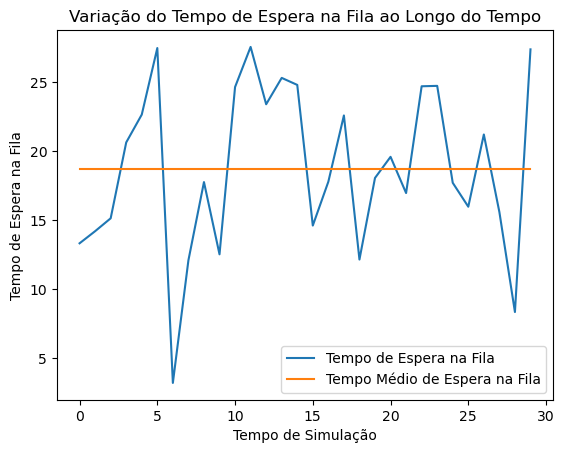

In [4]:
import matplotlib.pyplot as plt

# Obtendo os dados coletados durante a simulação
tempos_simulacao = range(len(metrics.waiting_times))
tempos_medios_espera = [metrics.calculate_average_waiting_time()] * len(metrics.waiting_times)

# Plotando o gráfico de linha
plt.plot(tempos_simulacao, metrics.waiting_times, label='Tempo de Espera na Fila')
plt.plot(tempos_simulacao, tempos_medios_espera, label='Tempo Médio de Espera na Fila')
plt.xlabel('Tempo de Simulação')
plt.ylabel('Tempo de Espera na Fila')
plt.title('Variação do Tempo de Espera na Fila ao Longo do Tempo')
plt.legend()
plt.show()
